# Chapter 8: Unification of the Fisherian and Neymanian Inferences in Randomized Experiments

In [1]:
from joblib import Parallel, delayed

import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
# viz
import matplotlib
import matplotlib.pyplot as plt
font = {'family' : 'IBM Plex Sans Condensed',
               'weight' : 'normal',
               'size'   : 10}
plt.rc('font', **font)
plt.rcParams['figure.figsize'] = (6, 6)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 1

%load_ext watermark
%watermark --iversions


statsmodels      : 0.13.5
scipy            : 1.10.0
matplotlib       : 3.6.3
matplotlib_inline: 0.1.6
numpy            : 1.23.5
pandas           : 1.5.2
seaborn          : 0.12.2



## FRT Simulation Study (sec 8.3)

In [2]:
def cafrt_stat_n(z, y):
    m = sm.OLS(y, sm.add_constant(z))
    m1, m2 = m.fit(), m.fit(cov_type="HC2")
    est, vse, rse = m1.params[1], m1.bse[1], m2.bse[1]
    return est, est/vse, est/rse

def cafrt_stat_f(z, y, x):
    m = sm.OLS(y, np.c_[sm.add_constant(z), x])
    m1, m2 = m.fit(), m.fit(cov_type="HC2")
    est, vse, rse = m1.params[1], m1.bse[1], m2.bse[1]
    return est, est/vse, est/rse

def cafrt_stat_l(z, y, x):
    Xmat = np.c_[sm.add_constant(z),
              x - x.mean(),
              z * (x - x.mean())]
    m = sm.OLS(y, Xmat)
    m1, m2 = m.fit(), m.fit(cov_type="HC2")
    est, vse, rse = m1.params[1], m1.bse[1], m2.bse[1]
    return est, est/vse, est/rse


In [3]:
def cafrt_pvalue(z, y, x, nfrt, k = 6):
    rr = sm.OLS(y, sm.add_constant(x)).fit().resid
    cafrt_stat_obs = np.r_[
        cafrt_stat_n(z, y),
        cafrt_stat_f(z, y, x),
        cafrt_stat_l(z, y, x),
        cafrt_stat_n(z, rr),
    ]

    def run_cafrt_pvalue(*args):
        zperm = np.random.permutation(z)
        return np.r_[
            cafrt_stat_n(zperm, y),
            cafrt_stat_f(zperm, y, x),
            cafrt_stat_l(zperm, y, x),
            cafrt_stat_n(zperm, rr),
            ]

    results = Parallel(n_jobs = k)(delayed(run_cafrt_pvalue)(i) for i in range(nfrt))
    cafrt_stat_perm = np.vstack(results)
    summ = 1*(np.abs(cafrt_stat_perm) - np.abs(cafrt_stat_obs) >= 0)
    return summ.mean(axis=0)


In [4]:
nfrt = int(500)
n, r = 100, 0.2
n1, n0 = int(r*n), int((1-r)*n)
sigma1, sigma0 = 1, 0.5
x = np.random.uniform(low = -1, high = 1, size=n)
y1 = x**3 + np.random.normal(scale=sigma1, size=n)
y0 = -x**3 + np.random.normal(scale=sigma0, size=n)
y1, y0 = y1 - y1.mean(), y0 - y0.mean()
zz = np.r_[np.ones(n1), np.zeros(n0)]


def simulation_frt():
    z = np.random.permutation(zz)
    y = z*y1 + (1-z)*y0
    return cafrt_pvalue(z, y, x, nfrt, k = 8)

simulation_frt()


array([0.52 , 0.52 , 0.646, 0.888, 0.888, 0.926, 0.85 , 0.85 , 0.9  ,
       0.89 , 0.89 , 0.93 ])

In [5]:
%%time
nmc = 500
res = []
for i in range(nmc):
    res.append(simulation_frt())
simres = np.vstack(res)
simres[:5, :]


CPU times: user 1min 24s, sys: 2.01 s, total: 1min 26s
Wall time: 1min 34s


array([[0.452, 0.452, 0.576, 0.504, 0.506, 0.654, 0.348, 0.294, 0.48 ,
        0.506, 0.506, 0.65 ],
       [0.76 , 0.76 , 0.798, 0.656, 0.656, 0.714, 0.968, 0.966, 0.966,
        0.654, 0.654, 0.71 ],
       [0.984, 0.984, 0.988, 0.918, 0.918, 0.938, 0.952, 0.95 , 0.962,
        0.918, 0.918, 0.938],
       [0.882, 0.882, 0.906, 0.94 , 0.94 , 0.954, 0.92 , 0.918, 0.944,
        0.94 , 0.94 , 0.954],
       [0.254, 0.254, 0.28 , 0.302, 0.3  , 0.424, 0.212, 0.18 , 0.268,
        0.298, 0.298, 0.414]])

In [6]:
simdata = [
    pd.DataFrame({
        "fac1" : "Unstudentized",
        "fac2" : "Neyman",
        "frt_pv": simres[:, 0],
    }),
    pd.DataFrame({
        "fac1" : "Studentized OLS",
        "fac2" : "Neyman",
        "frt_pv": simres[:, 1],
    }),
    pd.DataFrame({
        "fac1" : "Studentized EHW",
        "fac2" : "Neyman",
        "frt_pv": simres[:, 2],
    }),
    # fisher
    pd.DataFrame({
        "fac1" : "Unstudentized",
        "fac2" : "Fisher",
        "frt_pv": simres[:, 3],
    }),
    pd.DataFrame({
        "fac1" : "Studentized OLS",
        "fac2" : "Fisher",
        "frt_pv": simres[:, 4],
    }),
    pd.DataFrame({
        "fac1" : "Studentized EHW",
        "fac2" : "Fisher",
        "frt_pv": simres[:, 5],
    }),
    # lin
    pd.DataFrame({
        "fac1" : "Unstudentized",
        "fac2" : "Lin",
        "frt_pv": simres[:, 6],
    }),
    pd.DataFrame({
        "fac1" : "Studentized OLS",
        "fac2" : "Lin",
        "frt_pv": simres[:, 7],
    }),
    pd.DataFrame({
        "fac1" : "Studentized EHW",
        "fac2" : "Lin",
        "frt_pv": simres[:, 8],
    }),
    # rosenbaum
    pd.DataFrame({
        "fac1" : "Unstudentized",
        "fac2" : "Rosenbaum",
        "frt_pv": simres[:, 9],
    }),
    pd.DataFrame({
        "fac1" : "Studentized OLS",
        "fac2" : "Rosenbaum",
        "frt_pv": simres[:, 10],
    }),
    pd.DataFrame({
        "fac1" : "Studentized EHW",
        "fac2" : "Rosenbaum",
        "frt_pv": simres[:, 11],
    }),
]


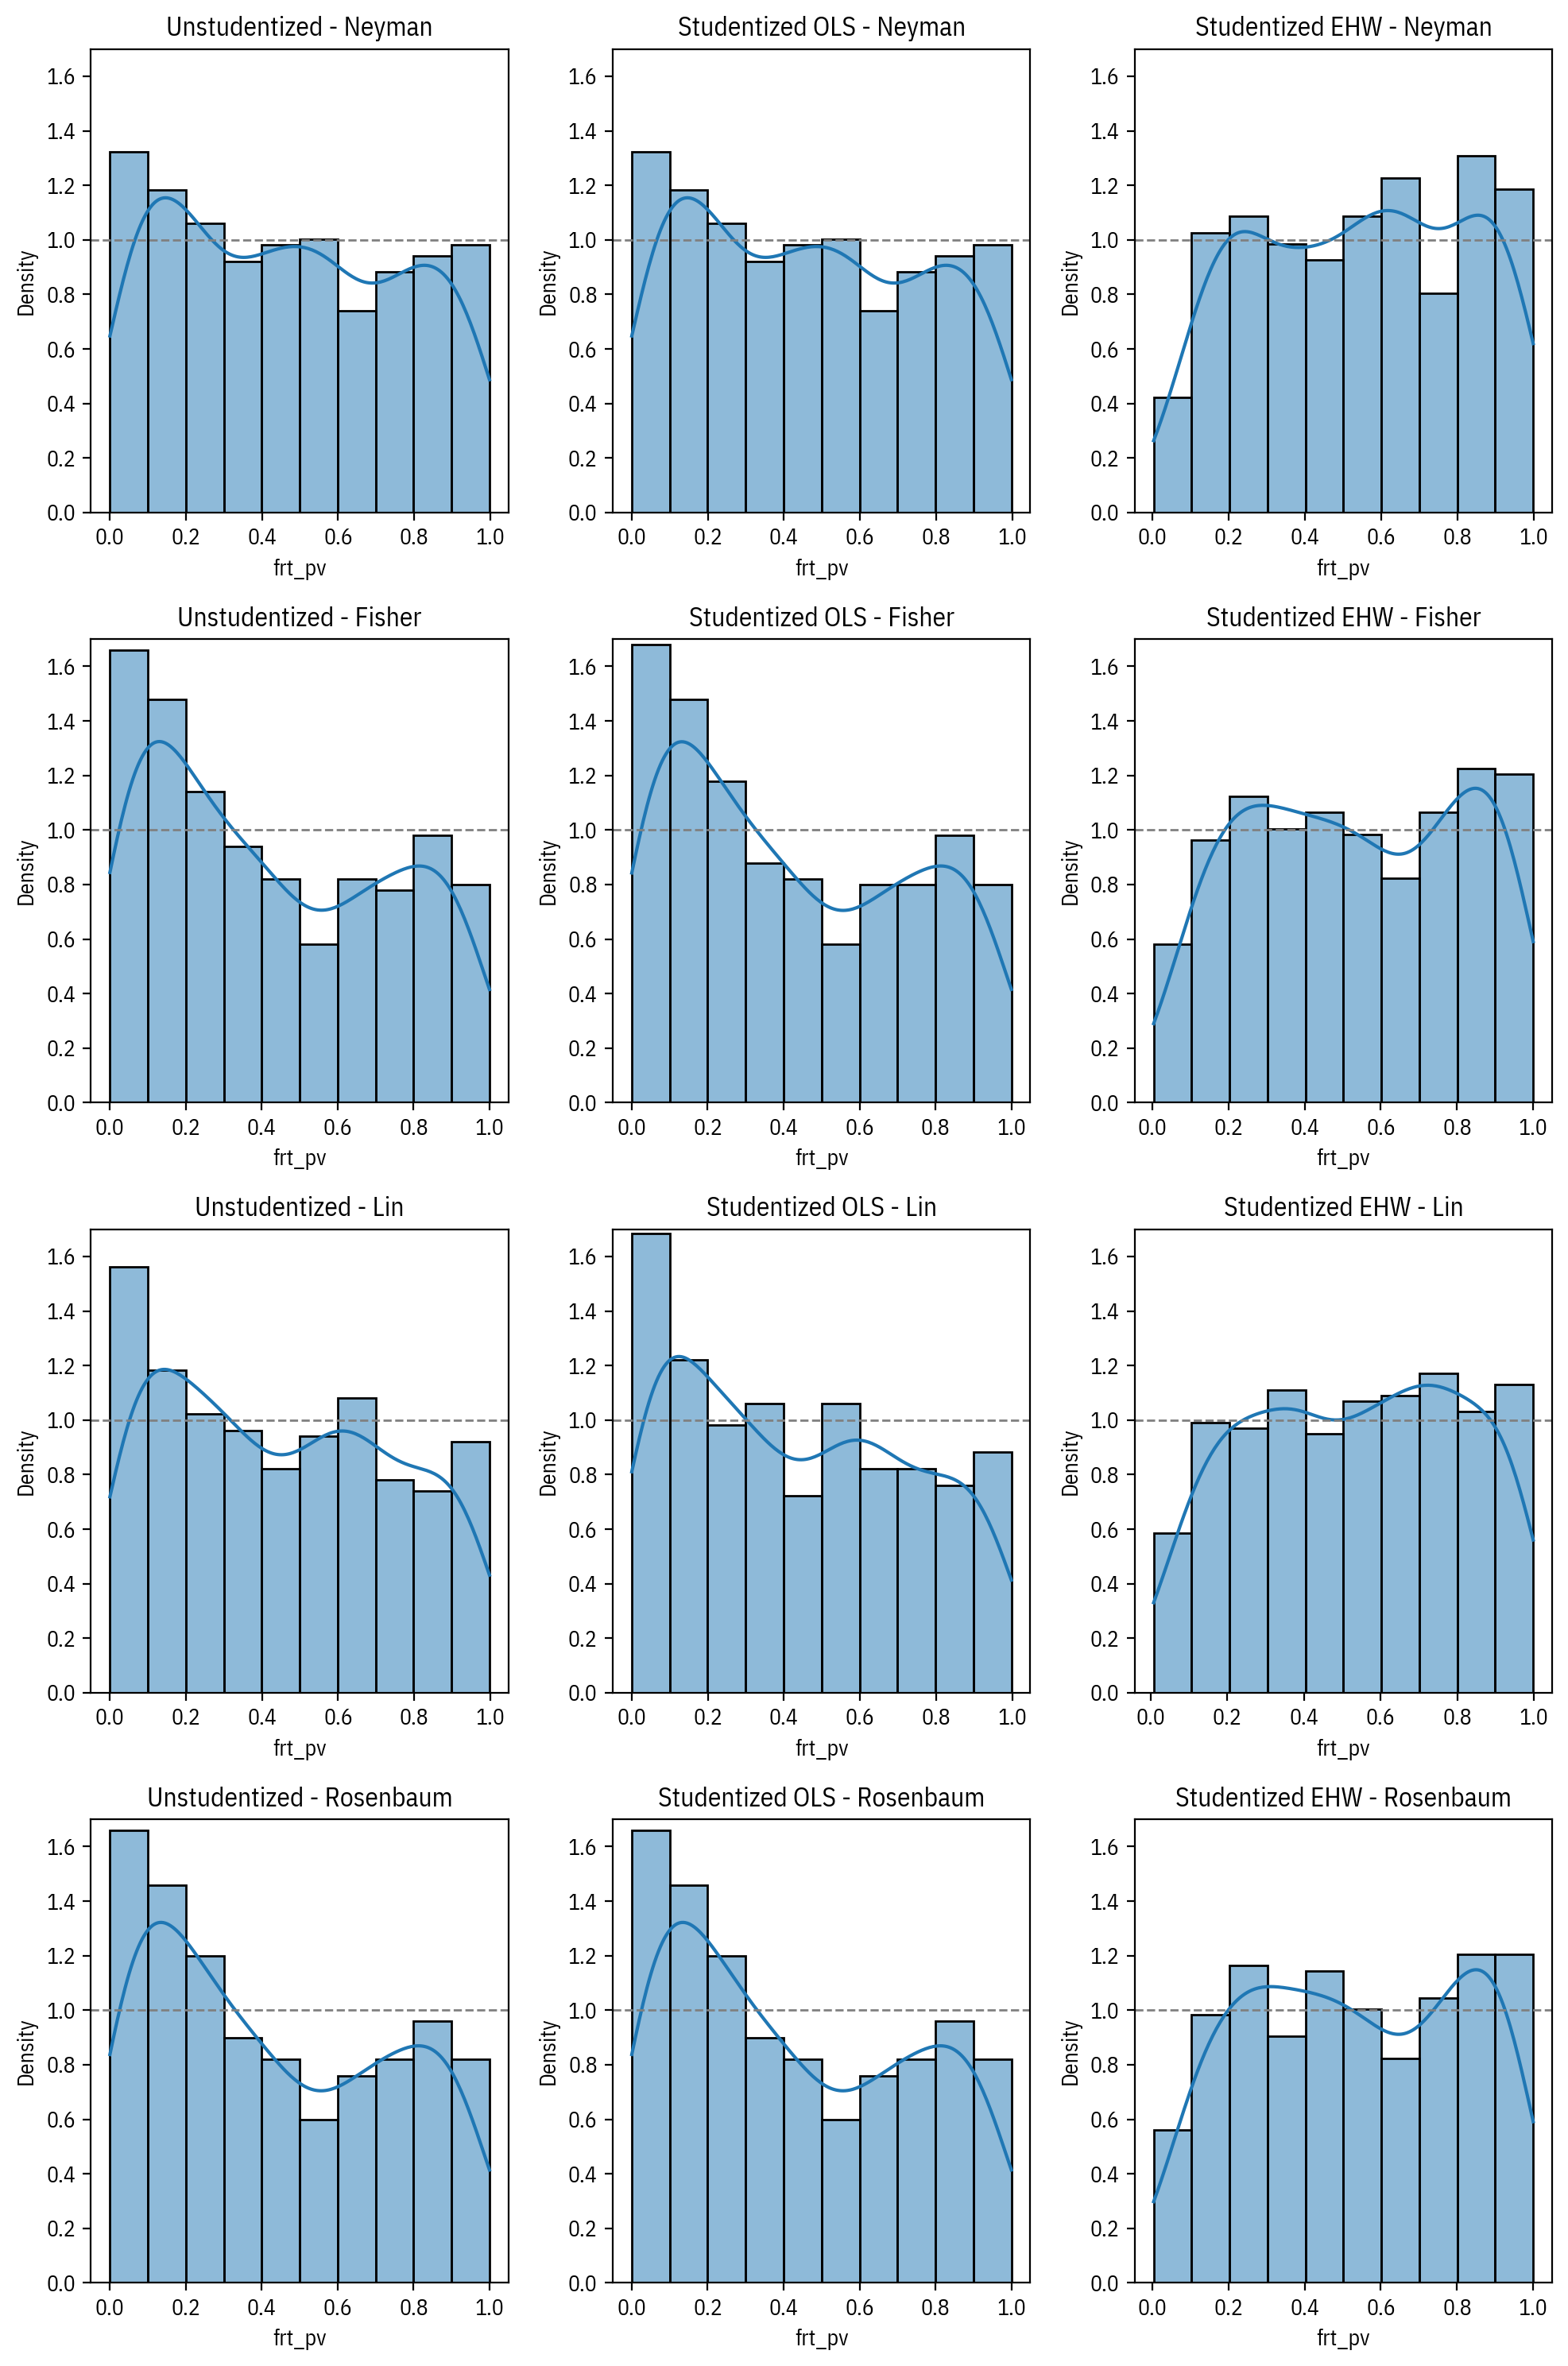

In [15]:
# create a figure with subplots
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(10, 15))

# loop through each dataframe and plot histogram
for i, df in enumerate(simdata):
    row = i // 3
    col = i % 3
    sns.histplot(data=df, x="frt_pv", hue="fac2", ax=axes[row, col],
                 kde = True, stat = 'density',
                 legend=False)
    axes[row, col].set_ylim(0, 1.7)
    axes[row, col].set_title(f"{df['fac1'][0]} - {df['fac2'][0]}")
[ax.axhline(y=1, linestyle='--', color='grey', linewidth=1) for ax in axes.flat]
# adjust spacing between subplots
plt.tight_layout()


## Case Study

In [8]:
def cre_stat(z, y, x):
    tau_n_fit = sm.OLS(y, sm.add_constant(z)).fit(cov_type="HC2")
    tau_l_fit = sm.OLS(y, np.c_[
                        sm.add_constant(z),
                        x - x.mean(axis=0),
                        z * (x - x.mean(axis=0))
                        ],
                       ).fit(cov_type="HC2")
    return np.r_[
        tau_n_fit.params[1], tau_n_fit.bse[1], tau_n_fit.tvalues[1],
        tau_l_fit.params[1], tau_l_fit.bse[1], tau_l_fit.tvalues[1],
        ]

def cre_frt(z, y, x, n_frt = 1e3):
    test_stat = cre_stat(z, y, x)
    # normal dist pvalue
    asy_p_n = 2 * sp.stats.norm.cdf(-np.abs(test_stat[2]))
    asy_p_l = 2 * sp.stats.norm.cdf(-np.abs(test_stat[5]))
    # FRT p value
    null_dist = (Parallel(n_jobs = 8)(
        delayed(cre_stat)(np.random.permutation(z), y, x) for i in range(n_frt))
    )
    null_dist = np.vstack(null_dist)
    comparisons =  1*(np.abs(null_dist) >= np.abs(test_stat))
    frt_p_n, frt_p_l = comparisons[:, 2].mean(), comparisons[:, 5].mean()

    restable = np.c_[
        np.r_[test_stat[0], test_stat[3]],
        np.r_[test_stat[1], test_stat[4]],
        np.r_[asy_p_n, asy_p_l],
        np.r_[frt_p_n, frt_p_l],
        ]
    res = pd.DataFrame(restable, index = ["Neyman", "Lin"],
                 columns=["Estimate", "Std. Error", "Asy. p-value", "FRT p-value"])
    return res, null_dist


In [9]:
dat_chong = pd.read_stata('chong.dta')
pd.crosstab(dat_chong.treatment, dat_chong.class_level)


class_level,1.0,2.0,3.0,4.0,5.0
treatment,,,,,
Soccer Player,16,19,15,10,10
Physician,17,20,15,11,10
Placebo,15,19,16,12,10


In [10]:
use_vars = ['treatment', 'gradesq34', 'class_level', 'anemic_base_re']
dat_physician = dat_chong.loc[dat_chong.treatment != "Soccer Player", use_vars]
dat_physician['z'] = np.where(dat_physician.treatment == "Physician", 1, 0)
dat_physician['y'] = dat_physician.gradesq34
dat_physician['x'] = np.where(dat_physician.anemic_base_re == "Yes", 1, 0)


In [11]:
for i in range(1, 6):
    dd = dat_physician.loc[dat_physician.class_level == i, ]
    print(i)
    print(cre_frt(dd.z, dd.y, dd.x, n_frt = int(1e3))[0])


1
        Estimate  Std. Error  Asy. p-value  FRT p-value
Neyman  0.567059    0.434951      0.192325        0.210
Lin     0.588021    0.439270      0.180690        0.213
2
        Estimate  Std. Error  Asy. p-value  FRT p-value
Neyman  0.193421    0.434236      0.656010        0.663
Lin     0.265317    0.433453      0.540471        0.553
3
        Estimate  Std. Error  Asy. p-value  FRT p-value
Neyman  1.305000    0.492392      0.008041        0.012
Lin     1.501344    0.459228      0.001078        0.002
4
        Estimate  Std. Error  Asy. p-value  FRT p-value
Neyman -0.273485    0.409249      0.503967        0.519
Lin    -0.312505    0.419068      0.455839        0.471
5
        Estimate  Std. Error  Asy. p-value  FRT p-value
Neyman -0.050000    0.379136      0.895080        0.891
Lin    -0.066667    0.249783      0.789548        0.775
